#DATA 620 Project 2
**Team 2:** Christophe Hunt, Joel Park, Ilya Kats, Pavan Akula, Nathan (Seoungyoon) Lim

###Project Description

The goal of the project is to create and analyze a two-node social network for sponsorship of bill and interests group affiliation within the U.S. Senate. Any mention of *bills* below implies *bills and resolutions*. Bills can be introduced by several senators, but only one, whose name appears first on the bill, is considered its sponsor. Senator may sponsor a bill for various reasons - because they support it, because they want to have a record of supporting it, because their constituents request it, and even to show support for bill's sponsor. Sometimes Senator may sponsor a bill to get campaign contributions to get elected to public office. Companies, labor unions, and other organizations spend billions of dollars each year on lobbying Congress and federal agencies. Before a bill is drafted Senator's staff, lobbyists and special interests groups work together tirelessly. Each bill is classified into a *subject* based on its *legislative* purpose. We will be analyzing the relationship between *Senators* and *Subjects* they are interested in. This type of social network is known as *affiliation* or *bipartite* networks.

###Specific project requirements:

- Identify a large two-node network dataset. Data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
- Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
- What can you infer about each of the distinct groups?

###We will be extracting following information from the data

- Senators presenting most bills
- Subjects on which most bills are presented.

###Data Source

For the project, we are analyzing affiliation between sponsors and subjects of bills within the U.S. Senate of the 114th Congress that met from January 3, 2015, to January 3, 2017. The official repository of the U.S. legislative data is Congress.gov. The bills data is also maintained by the U.S. Government Publishing Office. The data for the 114th Congress is available at https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/114/. The data is stored in XML format and contains a significant amount of metadata to describe a bill and its activity in Congress.

The public @unitedstates project maintains data and tools to access and analyze the governmental data including congressional data. Our primary data source is archived bills data from the 114th Congress prepared by the Sunlight Foundation. The data is saved in JSON format. Data access and format description is available at https://github.com/unitedstates/congress/wiki.

###Data Import

After downloading bills information from https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/114/, we have extracted required data and saved it to MySQL relational database on Google Cloud.

In [1]:
#Libraries used
import numpy as np
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite

In [2]:
#Retrieve data from cloud database
sql_con = pymysql.connect(host='104.196.212.179', port=3306, user='root', passwd='data620pw', db='billsdata')

query = ("SELECT senator, `subject`, COUNT(1) AS weight FROM "
        "(SELECT DISTINCT b.billId, b.title, s.`name` AS senator, ss.mainSubject as `subject` "
        "FROM sponsors s "
        "JOIN subjects ss ON s.billid = ss.billid "
        "JOIN bills b ON s.billid = b.billid ) a "
        "GROUP BY senator, `subject`;")

subjectInfo = pd.read_sql(query, con=sql_con)

#Small subset of data
query = ("SELECT senator, `subject`, COUNT(1) AS weight FROM "
        "(SELECT DISTINCT b.billId, b.title, s.`name` AS senator, ss.mainSubject AS `subject` "
        "FROM sponsors s "
        "JOIN subjects ss ON s.billid = ss.billid "
        "JOIN bills b ON s.billid = b.billid "
        "WHERE s.`name` IN ('Harry Reid','Elizabeth Warren', 'Mitch McConnell','Jeff Sessions','Bernard Sanders') ) a "
        "GROUP BY senator, `subject`")

smallSubset = pd.read_sql(query, con=sql_con)

sql_con.close()

#Seperate data into senators and billsubject
senatorsList = subjectInfo.senator.unique()
subjectList = subjectInfo.subject.unique()

senatorsList = senatorsList.tolist()
subjectList = subjectList.tolist()

#Small subset
subSetsenatorsList = smallSubset.senator.unique()
subSetsubjectList = smallSubset.subject.unique()

subSetsenatorsList = subSetsenatorsList.tolist()
subSetsubjectList = subSetsubjectList.tolist()

###Classification of bills sponsored by Senator based on subject.

In [3]:
#Weight shows number of bills presented on a subject by Senator
subjectInfo.sort_values(['weight'], ascending = False, inplace=True)
subjectInfo

senator                              subject  weight
710        Lisa Murkowski                               Energy      30
887        Orrin G. Hatch                             Taxation      23
204        Chuck Grassley                               Health      21
716        Lisa Murkowski   Public lands and natural resources      17
290          David Vitter                               Health      17
638            Jon Tester   Armed forces and national security      15
107          Bill Cassidy                               Health      15
645            Jon Tester                     Native Americans      14
280          David Vitter                             Commerce      13
1135        Sherrod Brown                               Health      13
859           Mike Rounds   Armed forces and national security      13
1090            Ron Wyden   Public lands and natural resources      13
199        Chuck Grassley            Crime and law enforcement      13
359      Edward J. Markey                               Energy      13
1093            Ron Wyden                             Taxation      12
761      Mark Steven Kirk   Armed forces and national security      12
465        Jeanne Shaheen   Armed forces and national security      12
626            John Thune                             Taxation      12
523           Jerry Moran   Armed forces and national security      11
769      Mark Steven Kirk                               Health      11
562         John Barrasso                     Native Americans      11
151    Charles E. Schumer            Crime and law enforcement      11
1050  Robert P. Jr. Casey                               Health      11
301           Dean Heller   Armed forces and national security      11
83     Benjamin L. Cardin                International affairs      11
1073          Ron Johnson   Government operations and politics      11
5              Al Franken                               Health      11
957    Richard Blumenthal   Armed forces and national security      10
872        Orrin G. Hatch            Crime and law enforcement      10
728           Marco Rubio                International affairs      10
...                   ...                                  ...     ...
623            John Thune                     Native Americans       1
629        Johnny Isakson         Economics and public finance       1
630        Johnny Isakson   Government operations and politics       1
572          John Boozman                               Energy       1
570          John Boozman              Arts, culture, religion       1
568          John Boozman                 Agriculture and food       1
546          Joe Donnelly                 Labor and employment       1
531           Jerry Moran                                  Law       1
533           Jerry Moran   Public lands and natural resources       1
534           Jerry Moran  Science, technology, communications       1
537           Jerry Moran          Water resources development       1
539          Joe Donnelly            Crime and law enforcement       1
540          Joe Donnelly                            Education       1
541          Joe Donnelly             Environmental protection       1
543          Joe Donnelly   Government operations and politics       1
544          Joe Donnelly                               Health       1
545          Joe Donnelly    Housing and community development       1
547          Joe Donnelly      Transportation and public works       1
566         John Barrasso      Transportation and public works       1
548       Joe Manchin III   Armed forces and national security       1
549       Joe Manchin III         Economics and public finance       1
551       Joe Manchin III         Finance and financial sector       1
552       Joe Manchin III   Government operations and politics       1
554       Joe Manchin III                 Labor and employment       1
555       Joe Manchin III   Public lands a

Lisa Murkowski is the Chairman of Committee on Energy and Natural Resources. Orrin G. Hatch is the Chairman of Committee on Finance.

###Two-mode Network Graph

Following graph shows two sets of nodes and relationships between sets. The first set of nodes are Senators and second set is a bill subject. Sets of nodes are related, but there is no relation between each set of nodes. This shows there is no connection between Senators. We can also notice there is no link between bill subjects.

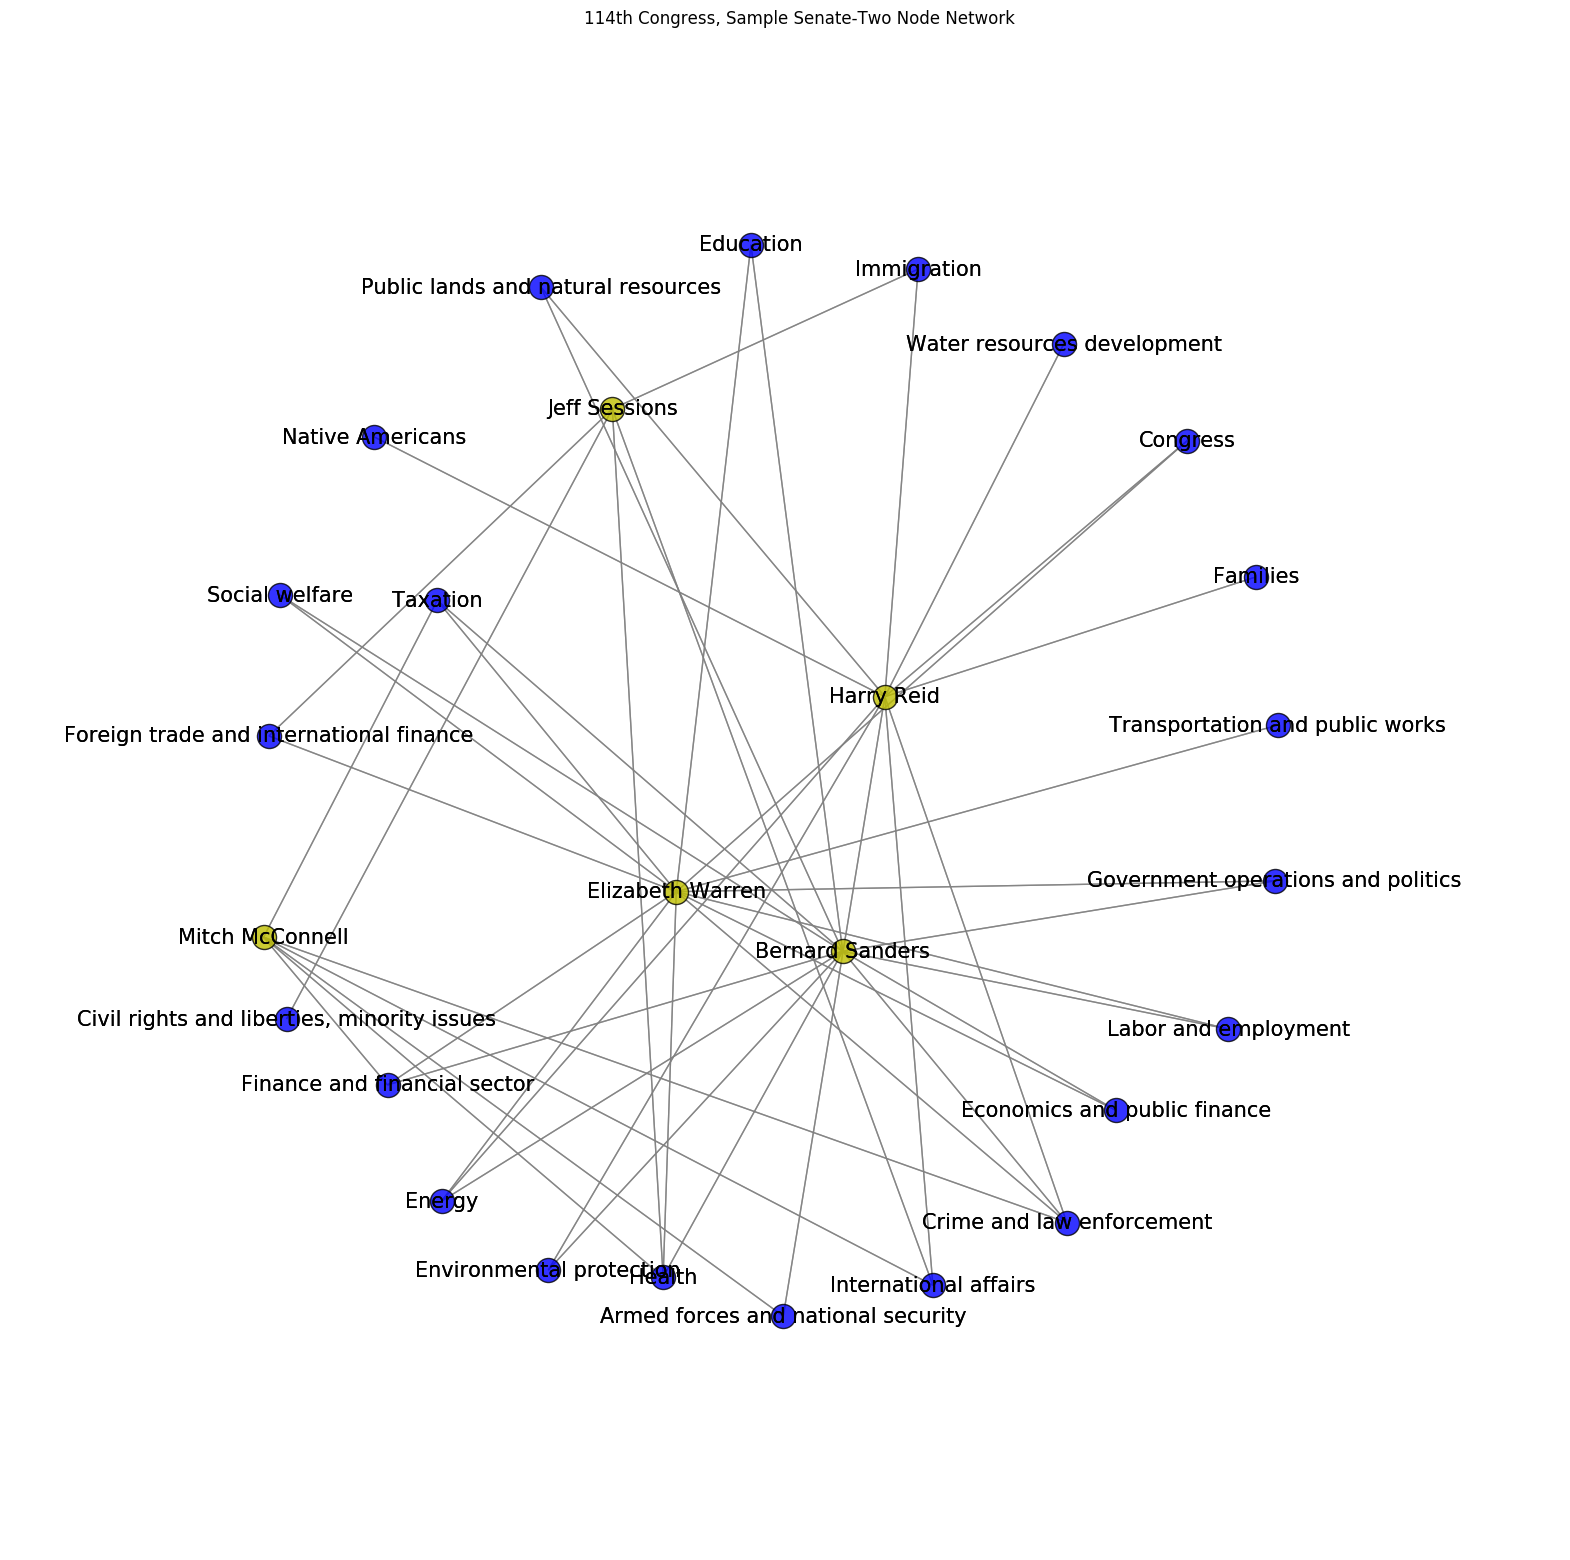

In [4]:
#Small subset data to show two-mode graph
%matplotlib inline

fig = plt.figure(figsize=(15, 15))
B = nx.Graph()
B.add_nodes_from(subSetsenatorsList, bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(subSetsubjectList, bipartite=1)

for index, row in smallSubset.iterrows():
    B.add_edge(row['senator'], row['subject'], weight=row['weight'])

#pos = nx.spring_layout(B, k=0.5, iterations=2)
pos = nx.spring_layout(B, k=0.5, iterations=25)
nx.draw(B, nodelist = subSetsenatorsList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'y', arrows=True)
nx.draw(B, nodelist = subSetsubjectList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b', arrows=True)

plt.title('114th Congress, Sample Senate-Two Node Network')
plt.show()

Following is an entire two-mode graph showing a relationship between Senators and bill subjects. We will be working with the whole dataset for the rest of the project.

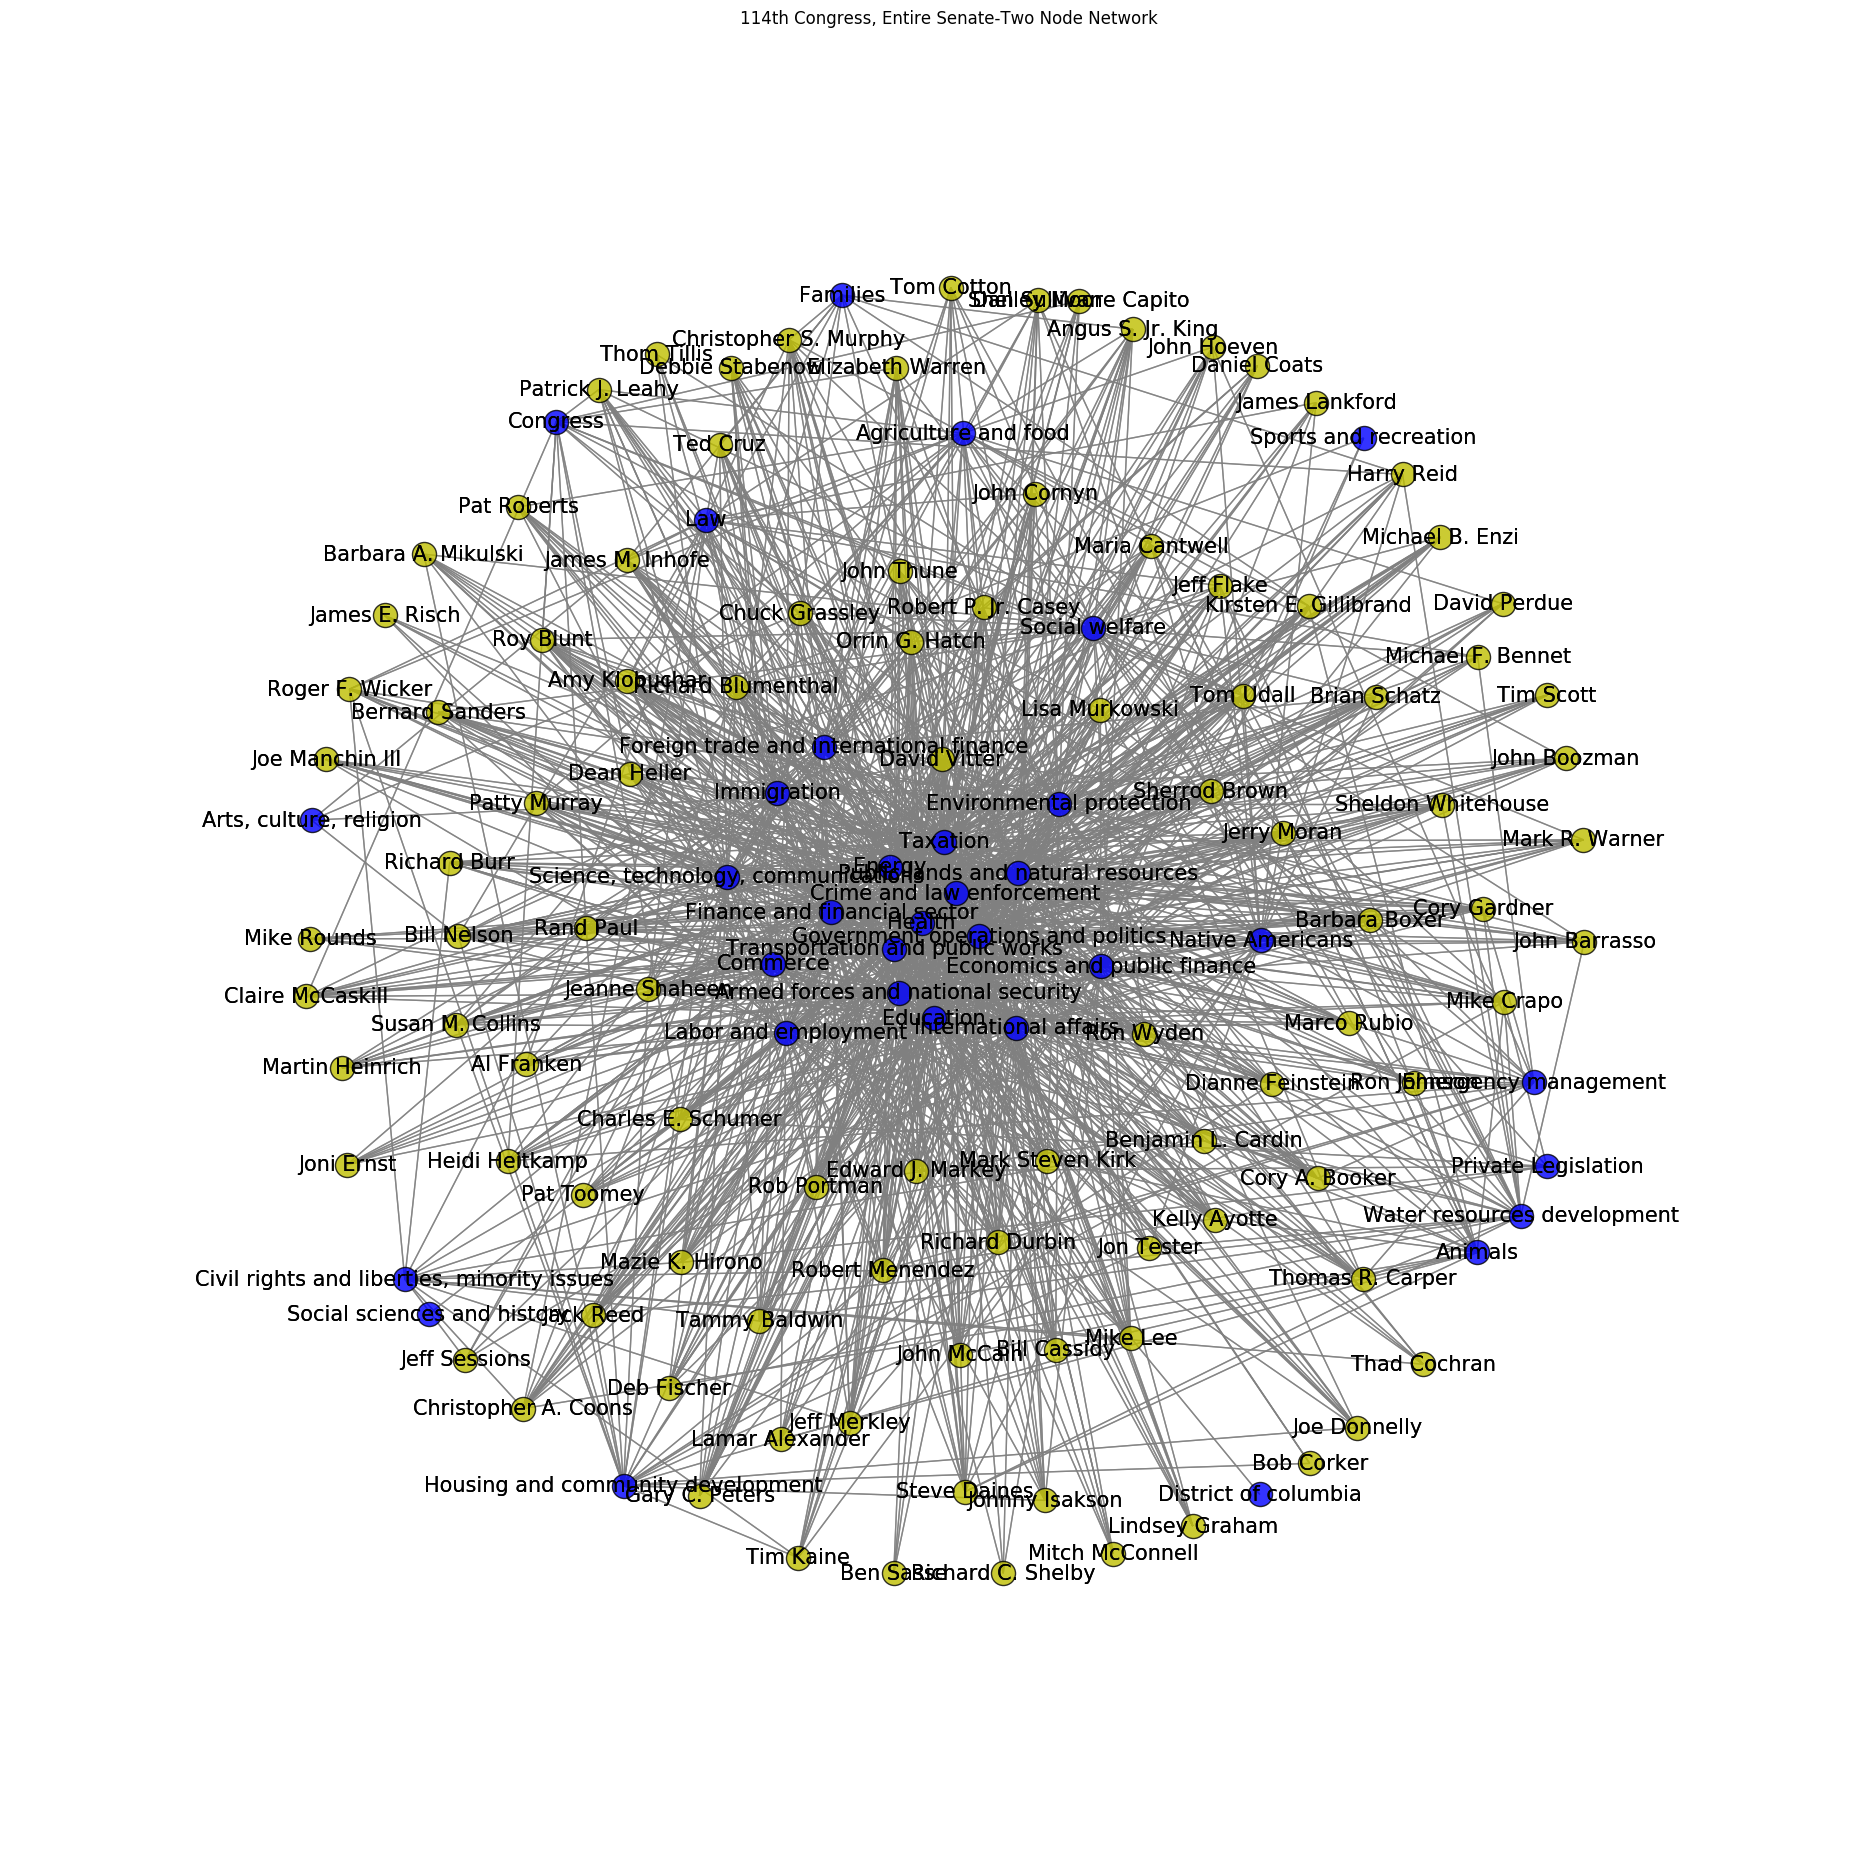

In [5]:
%matplotlib inline
fig = plt.figure(figsize=(18, 18))
B = nx.Graph()
B.add_nodes_from(senatorsList, bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(subjectList, bipartite=1)

for index, row in subjectInfo.iterrows():
    B.add_edge(row['senator'], row['subject'], weight=row['weight'])

#pos = nx.spring_layout(B, k=0.5, iterations=2)
pos = nx.spring_layout(B, k=0.3, iterations=75)
nx.draw(B, nodelist = senatorsList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'y', arrows=True)
nx.draw(B, nodelist = subjectList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b', arrows=True)

plt.title('114th Congress, Entire Senate-Two Node Network')
plt.show()

Get information about node sets. There are 100 Senators and 34 bill subjects.

In [6]:
#Graph can be queried to get information about node sets
top_nodes, bottom_nodes = bipartite.sets(B)

#Total of 100 Senators
print (len(top_nodes))

#Senators
df = pd.DataFrame(list(top_nodes), columns=['Subjects'])
df

34


Subjects
0                  Finance and financial sector
1                   Social sciences and history
2                     Crime and law enforcement
3                                     Education
4                  Economics and public finance
5                           Private Legislation
6                              Native Americans
7               Transportation and public works
8                                       Animals
9            Public lands and natural resources
10            Housing and community development
11                                     Families
12  Civil rights and liberties, minority issues
13                        International affairs
14                               Social welfare
15                                     Commerce
16                                       Energy
17          Science, technology, communications
18                         District of columbia
19                                  Immigration
20                      Arts, culture, religion
21                                     Taxation
22                                          Law
23           Armed forces and national security
24                                       Health
25                        Sports and recreation
26           Government operations and politics
27                     Environmental protection
28                         Emergency management
29                         Agriculture and food
30                         Labor and employment
31                                     Congress
32                  Water resources development
33      Foreign trade and international finance

In [7]:
#Total of 34 Bill Subjects
print (len(bottom_nodes))

#Bill Subjects
df = pd.DataFrame(list(bottom_nodes), columns=['Senators'])
df

100


Senators
0       Richard C. Shelby
1          Gary C. Peters
2          Cory A. Booker
3           Amy Klobuchar
4          Mark R. Warner
5             Bill Nelson
6          Lindsey Graham
7              Harry Reid
8             Rob Portman
9              Jon Tester
10         Heidi Heitkamp
11        Debbie Stabenow
12           Patty Murray
13         Maria Cantwell
14              Jack Reed
15            Mike Rounds
16             John Thune
17               Mike Lee
18        Bernard Sanders
19  Christopher S. Murphy
20         Chuck Grassley
21          Jeff Sessions
22         Johnny Isakson
23           Cory Gardner
24        James M. Inhofe
25      Angus S. Jr. King
26     Sheldon Whitehouse
27             Tom Cotton
28        Joe Manchin III
29             Bob Corker
..                    ...
70             Mike Crapo
71           John Boozman
72   Christopher A. Coons
73          Sherrod Brown
74            Jerry Moran
75           Richard Burr
76              Ben Sasse
77            Deb Fischer
78       Dianne Feinstein
79       Elizabeth Warren
80       Patrick J. Leahy
81     Richard Blumenthal
82            Pat Roberts
83            Ron Johnson
84           Dan Sullivan
85              Tim Scott
86         Jeanne Shaheen
87              Tim Kaine
88      Michael F. Bennet
89          Barbara Boxer
90             Al Franken
91          Tammy Baldwin
92        Robert Menendez
93       Susan M. Collins
94           Thad Cochran
95              Tom Udall
96           Jeff Merkley
97             Jeff Flake
98        Lamar Alexander
99            John McCain

[100 rows x 1 columns]

In [8]:
#Get total number of nodes in the graph (Senators + Bill Subjects)
bipartite.sets(B)
nx.number_of_nodes(B)

134

In [9]:
#Diameter of the graph. Total number of bill presented by Senators during 114th congress.
print(B.size())

1265


In [10]:
#Displays information how nodes are grouped inside the graph
#Senators bipartite value is 1 and bill subject bipartite value is 0
df = pd.DataFrame(list(bipartite.color(B).items()), columns=['Node', 'bipartite'])
df.sort_values(['bipartite', 'Node'], ascending = True, inplace=True)
df

Node  bipartite
109                                   Al Franken          0
19                                 Amy Klobuchar          0
77                             Angus S. Jr. King          0
33                           Barbara A. Mikulski          0
107                                Barbara Boxer          0
32                                     Ben Sasse          0
4                             Benjamin L. Cardin          0
54                               Bernard Sanders          0
94                                  Bill Cassidy          0
59                                   Bill Nelson          0
88                                    Bob Corker          0
117                                 Brian Schatz          0
102                           Charles E. Schumer          0
53                          Christopher A. Coons          0
64                         Christopher S. Murphy          0
66                                Chuck Grassley          0
123                             Claire McCaskill          0
14                                Cory A. Booker          0
73                                  Cory Gardner          0
96                                  Dan Sullivan          0
105                                 Daniel Coats          0
119                                 David Perdue          0
23                                  David Vitter          0
91                                   Dean Heller          0
72                                   Deb Fischer          0
43                               Debbie Stabenow          0
79                              Dianne Feinstein          0
22                              Edward J. Markey          0
82                              Elizabeth Warren          0
10                                Gary C. Peters          0
..                                           ...        ...
17   Civil rights and liberties, minority issues          1
7                                       Commerce          1
61                                      Congress          1
70                     Crime and law enforcement          1
95                          District of columbia          1
126                 Economics and public finance          1
74                                     Education          1
115                         Emergency management          1
93                                        Energy          1
113                     Environmental protection          1
65                                      Families          1
67                  Finance and financial sector          1
1        Foreign trade and international finance          1
36            Government operations and politics          1
35                                        Health          1
15             Housing and community development          1
122                                  Immigration          1
0                          International affairs          1
125                         Labor and employment          1
34                                           Law          1
68                              Native Americans          1
55                           Private Legislation          1
81            Public lands and natural resources          1
26           Science, technology, communications          1
2                    Social sciences and history          1
90                                Social welfare          1
103                        Sports and recreation          1
100                                     Taxation          1
80               Transportation and public works          1
58                   Water resources development          1

[134 rows x 2 columns]

#Metrics and Inference

###Shortest Path

Function *shortest_path_length* of *NetworkX* library allows us to find the *Shortest Path* from a specific origin to a specified destination in a given network while minimizing the total cost associated with the path. 

In our case, *shortest path* metric shows, bills sponsored by Senator Amy Klobuchar on subjects *Health* and *Science, technology, communications* make it to the floor faster compared to Senator Tom Cotton and Senator Tom Udall.

Example:
Minnesota Democratic Senator Amy Klobuchar has sponsored bills on subjects *Health* and *Science, technology, communications*. She and her staff have more experience than Arkansas Republican Senator Tom Cotton in getting these bills through committees and onto the Senate floor. If people of Arkansas want any legislation introduced related to *Health* and *Science, technology, communications* their chances of getting the bill onto the floor through Senator Amy Klobuchar are very high compared to   Senator Tom Cotton.

In [11]:
#Gives information about average shortest path between Senators and Subjects. 
#Every Senator has at least two subjects common with other Senators.
nx.average_shortest_path_length(B)

2.116934126360678

In [12]:
#Shortest path between Senators and bill subjects
#Value is close to average shortest path.
df = pd.DataFrame(list(bipartite.color(B).items()), columns=['Node', 'bipartite'])
df1 = df[(df.bipartite == 1)]
df2 = df[(df.bipartite == 0)]

cols = ['Subject', 'Senator', 'ShortestPath']
lst = []
for i1, m1 in df1.iterrows():
    for i2, m2 in df2.iterrows():
        s1 = m1[0]
        s2 = m2[0]
        e = False
        if [s1, s2, nx.shortest_path_length(B, s1, s2)] in lst:
            e = True
        if [s2, s1, nx.shortest_path_length(B, s1, s2)] in lst:
            e = True
        if not e:
            lst.append([s1, s2, nx.shortest_path_length(B, s1, s2)])

ShortPath = pd.DataFrame(lst, columns=cols)
ShortPath.sort_values(['ShortestPath', 'Subject', 'Senator'], ascending = True, inplace=True)
ShortPath

Subject                Senator  ShortestPath
3012         Agriculture and food          Amy Klobuchar             1
3057         Agriculture and food      Angus S. Jr. King             1
3049         Agriculture and food  Christopher S. Murphy             1
3050         Agriculture and food         Chuck Grassley             1
3071         Agriculture and food           Dan Sullivan             1
3088         Agriculture and food           David Perdue             1
3016         Agriculture and food           David Vitter             1
3055         Agriculture and food        James M. Inhofe             1
3074         Agriculture and food         Jeanne Shaheen             1
3094         Agriculture and food             Jeff Flake             1
3046         Agriculture and food            Jerry Moran             1
3040         Agriculture and food           John Boozman             1
3098         Agriculture and food            John Hoeven             1
3020         Agriculture and food  Kirsten E. Gillibrand             1
3095         Agriculture and food         Lisa Murkowski             1
3048         Agriculture and food               Mike Lee             1
3080         Agriculture and food            Pat Roberts             1
3062         Agriculture and food       Patrick J. Leahy             1
3032         Agriculture and food           Patty Murray             1
3063         Agriculture and food     Richard Blumenthal             1
3028         Agriculture and food         Richard Durbin             1
3083         Agriculture and food        Robert Menendez             1
3017         Agriculture and food    Robert P. Jr. Casey             1
3061         Agriculture and food        Roger F. Wicker             1
3067         Agriculture and food            Ron Johnson             1
3084         Agriculture and food       Susan M. Collins             1
3092         Agriculture and food              Tom Udall             1
401                       Animals     Benjamin L. Cardin             1
470                       Animals           Bill Cassidy             1
441                       Animals   Christopher A. Coons             1
...                           ...                    ...           ...
1337  Water resources development        Michael B. Enzi             3
1377  Water resources development      Michael F. Bennet             3
1348  Water resources development               Mike Lee             3
1339  Water resources development            Mike Rounds             3
1310  Water resources development        Mitch McConnell             3
1333  Water resources development         Orrin G. Hatch             3
1380  Water resources development            Pat Roberts             3
1307  Water resources development             Pat Toomey             3
1362  Water resources development       Patrick J. Leahy             3
1332  Water resources development           Patty Murray             3
1372  Water resources development              Rand Paul             3
1363  Water resources development     Richard Blumenthal             3
1397  Water resources development           Richard Burr             3
1302  Water resources development      Richard C. Shelby             3
1328  Water resources development         Richard Durbin             3
1327  Water resources development            Rob Portman             3
1383  Water resources development        Robert Menendez             3
1317  Water resources development    Robert P. Jr. Casey             3
1361  Water resources development        Roger F. Wicker             3
1367  Water resources development            Ron Johnson             3
1329  Water resources development              Roy Blunt             3
1393  Water resources development   Shelley Moore Capito             3
1343  Water resources development          Sherrod Brown             3
1384  Water resources development       Susan M. Collins             3
1305  Water resources development               Te

###Node centralities

We will be showing metrics

- Closeness - Closeness is the inverse sum of all shortest paths
- Betweenness - Number of shortest paths that pass through a node
- Degree - The number other nodes that a node is connected to

In our case, *Health* and *Taxation* top the list in all three metrics. In other words, both subjects unite Senators closely than any other subject. Subject *District of Columbia* least popular among Senators.

In [13]:
#Closeness Betweenness Degrees centrality between Senetors and Subjects
close = nx.closeness_centrality(B)
between = nx.betweenness_centrality(B)
degree = nx.degree_centrality(B)
df1 = pd.DataFrame(list(close.items()), columns=['Node', 'Closeness'])
df2 = pd.DataFrame(list(between.items()), columns=['Node', 'Betweenness'])
df3 = pd.DataFrame(list(degree.items()), columns=['Node', 'Degrees'])
df = df1.join(df2.set_index('Node'), on='Node').join(df3.set_index('Node'), on='Node')
df.sort_values(['Closeness', 'Betweenness','Degrees'], ascending = False, inplace=True)
df

Node  Closeness  Betweenness  \
100                                       Health   0.692708     0.101990   
124                                     Taxation   0.651961     0.081904   
77            Public lands and natural resources   0.604545     0.064795   
35            Government operations and politics   0.599099     0.063533   
103           Armed forces and national security   0.588496     0.064645   
97                     Crime and law enforcement   0.545082     0.045923   
76               Transportation and public works   0.545082     0.042655   
70                                     Education   0.527778     0.035685   
23                                  David Vitter   0.523622     0.008982   
24                         International affairs   0.519531     0.046628   
63                  Finance and financial sector   0.515504     0.036473   
111                     Environmental protection   0.515504     0.033388   
19                                 Amy Klobuchar   0.515504     0.006491   
127                                   Jeff Flake   0.511538     0.006419   
95                                Jeanne Shaheen   0.507634     0.006398   
133                               Orrin G. Hatch   0.507634     0.005318   
99                            Charles E. Schumer   0.503788     0.021357   
60                                      Mike Lee   0.503788     0.019391   
118                                    Tom Udall   0.503788     0.009767   
105                           Richard Blumenthal   0.503788     0.009606   
109                              Robert Menendez   0.503788     0.006964   
10                                     Ron Wyden   0.503788     0.005168   
39                                Richard Durbin   0.503788     0.004653   
38                                   Rob Portman   0.503788     0.004406   
27                              Mark Steven Kirk   0.503788     0.004089   
71                               James M. Inhofe   0.500000     0.008501   
34                                   Bill Nelson   0.500000     0.007933   
48                                    Mike Crapo   0.500000     0.006094   
75                              Dianne Feinstein   0.500000     0.005646   
59                                   Marco Rubio   0.500000     0.004304   
..                                           ...        ...          ...   
130                              Lamar Alexander   0.458621     0.000788   
126                         Shelley Moore Capito   0.458621     0.000670   
112                                 Thad Cochran   0.458621     0.000557   
16                               Mitch McConnell   0.458621     0.000255   
65                                 Jeff Sessions   0.449324     0.000474   
66                                     Ben Sasse   0.449324     0.000134   
13                  Economics and public finance   0.446309     0.015759   
50                                   Mike Rounds   0.446309     0.000284   
32                             Richard C. Shelby   0.446309     0.000151   
120                                  Immigration   0.443333     0.015822   
85                                Social welfare   0.443333     0.014690   
1        Foreign trade and international finance   0.437500     0.015152   
30                                   Thom Tillis   0.437500     0.000262   
7                                 James E. Risch   0.437500     0.000176   
114                         Agriculture and food   0.423567     0.008114   
11                              Native Americans   0.420886     0.008903   
33                                           Law   0.418239     0.006880   
15             Housing and community development   0.413043     0.007747   
56                   Water resources development   0.407975     0.004550   
12                                       Animals   0.398204     0.003565   
125                                     Congress   0.393491     0.002552   
102  Civil right

###Projection

According to the article published by Tore Opsahl, on https://toreopsahl.com/tnet/two-mode-networks/, *Projection* is described as *transforming a two-mode network into a one-mode network*. The process works by selecting one set of nodes and linking two nodes if they are connected to the same node of the other set.

Following is the projected graph of Senators.

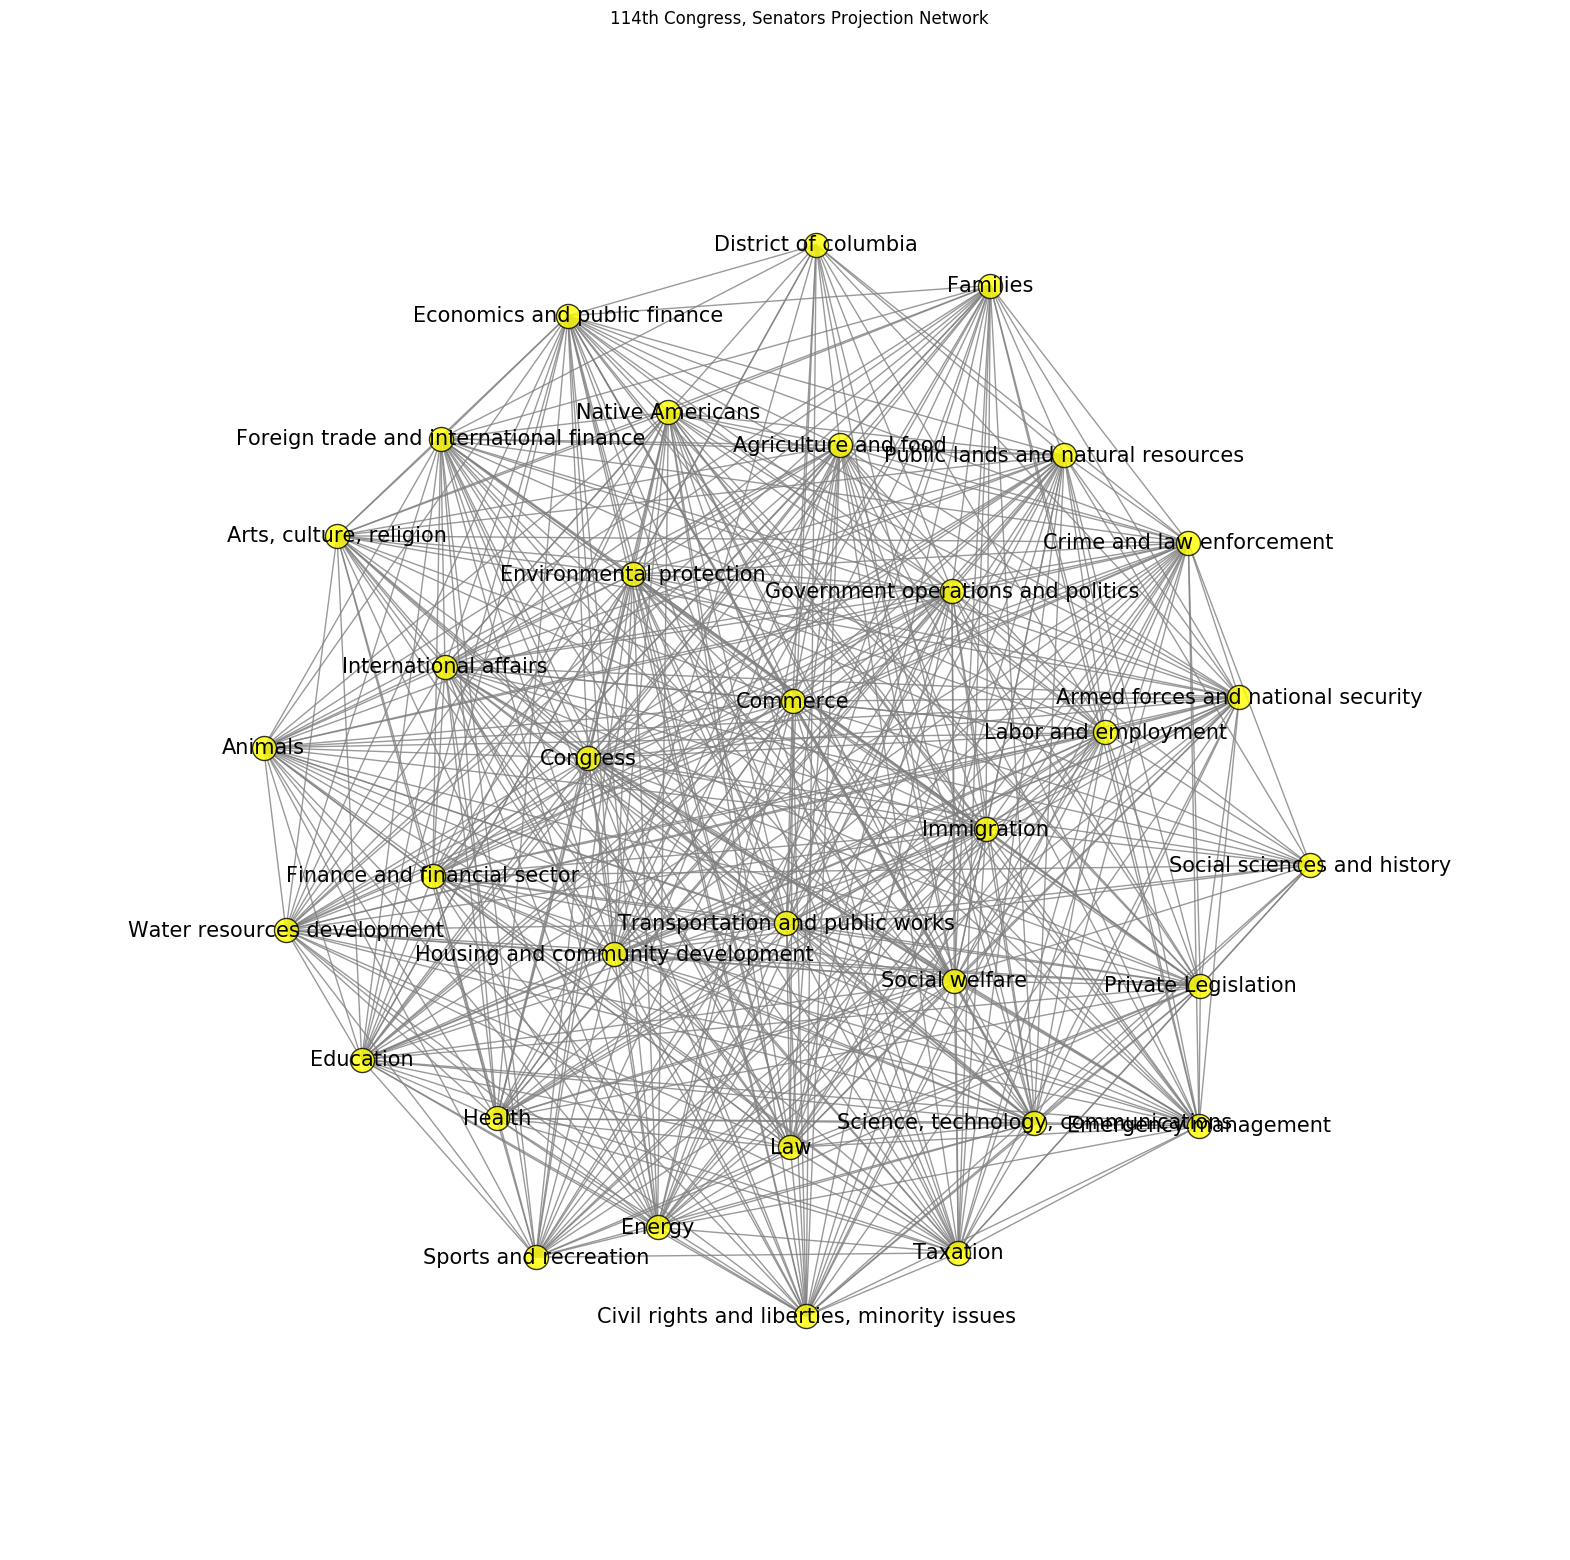

In [14]:
#Graph shows Senators are tightly connected.
G = bipartite.projected_graph(B, top_nodes, multigraph=False)

%matplotlib inline
fig = plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G, k=0.6, iterations=25)
nx.draw(G, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'yellow')
plt.title('114th Congress, Senators Projection Network')
plt.show()

Following network is projected graph of bill subjects. 

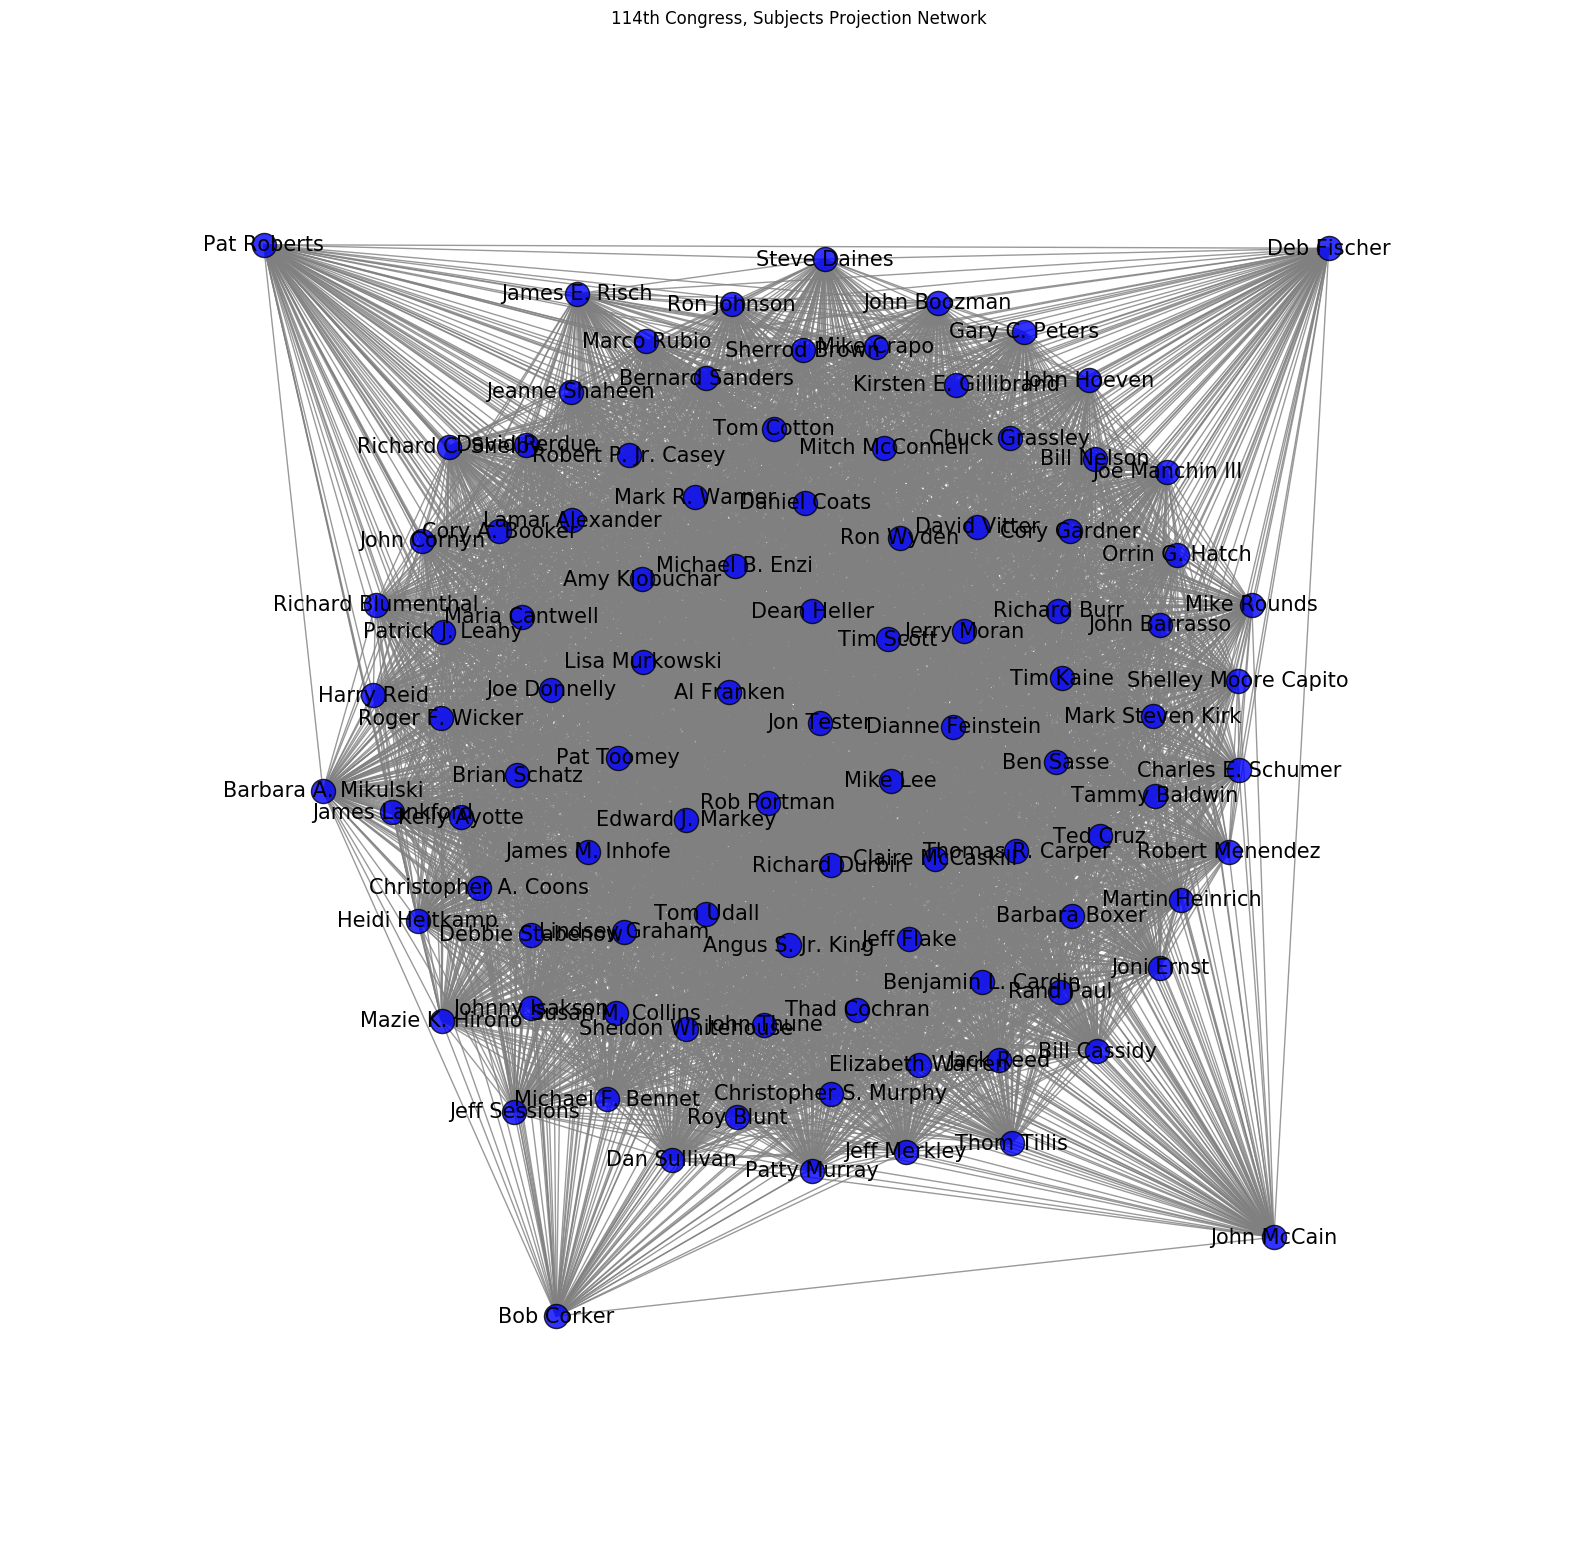

In [15]:
#Graph shows they are connected to the most part.
#Not all subjects are linked. Example: Social sciences & history and District of Columbia
#They were least popular among Senators

G = bipartite.projected_graph(B, bottom_nodes, multigraph=False)

%matplotlib inline
fig = plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G, k=0.5, iterations=25)
nx.draw(G, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b')
plt.title('114th Congress, Subjects Projection Network')
plt.show()

###Density

A Dense graph is a graph in which the number of edges is close to the maximal number of edges. Following shows nodes in each node-set are evenly dense. Output suggests it is not a dense graph.

In [16]:
#Density
print(bipartite.density(B,top_nodes))

print(bipartite.density(B,bottom_nodes))

0.3720588235294118
0.3720588235294118


###Clustering

Two-mode clustering metrics show there is a high level of clustering around Senators Gary C. Peters, Senator Edward J. Markey and Senator Amy Klobuchar. In other words Senators are creating clusters around subjects. We can assume that Senators are more actively working on subjects.

In [17]:
c = bipartite.clustering(B)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Clustering'])
df.sort_values(['Clustering', 'Node'], ascending = False, inplace=True)
df

Node  Clustering
9                                 Gary C. Peters    0.467979
43                              Edward J. Markey    0.466050
19                                 Amy Klobuchar    0.465132
38                                   Rob Portman    0.458394
27                              Mark Steven Kirk    0.457735
22                                  Patty Murray    0.449602
108                                Tammy Baldwin    0.443799
115                                 Brian Schatz    0.443223
133                               Orrin G. Hatch    0.438549
40                                     Roy Blunt    0.433688
104                                Barbara Boxer    0.429799
86                                   Dean Heller    0.428701
10                                     Ron Wyden    0.428436
64                                  Kelly Ayotte    0.427624
39                                Richard Durbin    0.424544
89                         Kirsten E. Gillibrand    0.424226
36                                   John Cornyn    0.423339
23                                  David Vitter    0.422189
95                                Jeanne Shaheen    0.421120
47                               Michael B. Enzi    0.416889
28                                  Bill Cassidy    0.415656
69                                  Cory Gardner    0.414451
58                                   Jerry Moran    0.406920
14                                Cory A. Booker    0.406413
122                                   John Thune    0.406024
131                              Bernard Sanders    0.404171
59                                   Marco Rubio    0.402996
61                         Christopher S. Murphy    0.402861
57                            Sheldon Whitehouse    0.398786
127                                   Jeff Flake    0.398304
..                                           ...         ...
45                                James Lankford    0.248444
37                                    Harry Reid    0.244810
117                                 David Perdue    0.236183
112                                 Thad Cochran    0.228641
13                  Economics and public finance    0.218295
85                                Social welfare    0.214168
120                                  Immigration    0.211763
33                                           Law    0.207037
114                         Agriculture and food    0.205080
7                                 James E. Risch    0.201195
1        Foreign trade and international finance    0.200920
50                                   Mike Rounds    0.189306
66                                     Ben Sasse    0.185288
11                              Native Americans    0.174577
56                   Water resources development    0.169541
15             Housing and community development    0.167055
30                                   Thom Tillis    0.165161
32                             Richard C. Shelby    0.164930
65                                 Jeff Sessions    0.153204
12                                       Animals    0.148732
113                         Emergency management    0.145375
102  Civil rights and liberties, minority issues    0.126924
125                                     Congress    0.118515
78                                      Families    0.118401
83                                    Bob Corker    0.101726
73                           Private Legislation    0.082698
29                       Arts, culture, religion    0.053245
128                        Sports and recreation    0.042717
2                    Social sciences and history    0.032616
91                          District of columbia    0.025329

[134 rows x 2 columns]

###Local clustering coefficient for two-mode networks

Clustering values obtained using *Robins Alexander method* and *Global Average Method* differ because *Robins Alexander method* clustering coefficients for two-mode networks are based on 4-cycles, which is the smallest possible cycle in two-mode networks. Robins and Alexander defined a coefficient as the ratio between the number of 4-cycles and the number of 3-paths.

Whereas *Global Average Method* uses one-mode clustering coefficient to detect closure among three nodes. Hence the difference in values.

Reference: https://toreopsahl.com/tnet/two-mode-networks/clustering/

In [18]:
#Average clustering Robins Alexander method
print(round(bipartite.robins_alexander_clustering(B), 3))

#Average clustering
print(round(bipartite.average_clustering(B), 3))

0.552
0.316


###Subgroups

This occurrence of situations in which the nodes of a graph fall into two or more groups with some nodes acting as links between the groups. Following table shows subgroup formation between two different node sets.

In [19]:
def get_triangles(g):
    nodes = g.nodes()
    for n1 in nodes:
        neighbors1 = set(g[n1])
        for n2 in filter(lambda x: x>n1, nodes):
            neighbors2 = set(g[n2])
            common = neighbors1 & neighbors2
            for n3 in filter(lambda x: x>n2, common):
                yield n1, n2, n3
a = get_triangles(B)
df = pd.DataFrame(a)
df.columns = ['node1', 'node2', 'node3']
df

node1                                node2  \
0      International affairs  Science, technology, communications   
1      International affairs  Science, technology, communications   
2      International affairs  Science, technology, communications   
3      International affairs                                  Law   
4      International affairs                                  Law   
5      International affairs                                  Law   
6      International affairs                                  Law   
7      International affairs                                  Law   
8      International affairs                  Private Legislation   
9      International affairs                     Native Americans   
10     International affairs                     Native Americans   
11     International affairs                     Native Americans   
12     International affairs                     Native Americans   
13     International affairs   Public lands and natural resources   
14     International affairs   Public lands and natural resources   
15     International affairs   Public lands and natural resources   
16     International affairs   Public lands and natural resources   
17     International affairs   Public lands and natural resources   
18     International affairs   Public lands and natural resources   
19     International affairs   Public lands and natural resources   
20     International affairs   Public lands and natural resources   
21     International affairs   Public lands and natural resources   
22     International affairs   Public lands and natural resources   
23     International affairs                       Social welfare   
24     International affairs                       Social welfare   
25     International affairs                             Taxation   
26     International affairs                             Taxation   
27     International affairs                             Taxation   
28     International affairs                Sports and recreation   
29     International affairs                 Labor and employment   
...                      ...                                  ...   
12902        Martin Heinrich                            Roy Blunt   
12903        Martin Heinrich                       Orrin G. Hatch   
12904        Martin Heinrich                       Orrin G. Hatch   
12905        Martin Heinrich                       Orrin G. Hatch   
12906        Martin Heinrich                      Michael B. Enzi   
12907        Martin Heinrich                      Michael B. Enzi   
12908        Martin Heinrich                           Mike Crapo   
12909        Martin Heinrich                           Mike Crapo   
12910        Martin Heinrich                           Mike Crapo   
12911        Martin Heinrich                          Mike Rounds   
12912        Martin Heinrich                        Sherrod Brown   
12913        Martin Heinrich                             Mike Lee   
12914        Martin Heinrich                             Mike Lee   
12915        Martin Heinrich                   Sheldon Whitehouse   
12916        Martin Heinrich                     Patrick J. Leahy   
12917        Martin Heinrich                     Patrick J. Leahy   
12918        Martin Heinrich                          Pat Roberts   
12919        Martin Heinrich                          Pat Roberts   
12920        Martin Heinrich                          Ron Johnson   
12921        Martin Heinrich                           Pat Toomey   
12922        Martin Heinrich                            Rand Paul   
12923        Martin Heinrich                    Michael F. Bennet   
12924        Martin Heinrich                    Michael F. Bennet   
12925        Martin Heinrich                   Richard Blumenthal   
12926        Martin Heinrich                   Richard Blumenthal   
12927        Martin Heinrich                        Tammy Baldwin   
12928        Martin H

###Cliques

A clique is defined as a maximal complete subgraph of a given graph. Example: a group of nodes where every node is connected directly to every other node. The word *maximal* means that no other nodes can be added to the clique without making it less connected.

When the entire two-node graph is checked for cliques, bill subjects *Health* and *Taxation* ranked on the top. This explains Senator connecting to these bill subjects make a complete subgraph or a clique.

Bill subjects *Health* and *Taxation* connect more Senators, creating more cliques.

In [20]:
c = nx.number_of_cliques(B)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Cliques'])
df.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
df

Node  Cliques
100                                   Health       88
124                                 Taxation       82
77        Public lands and natural resources       73
35        Government operations and politics       72
103       Armed forces and national security       71
76           Transportation and public works       61
97                 Crime and law enforcement       61
70                                 Education       58
24                     International affairs       55
63              Finance and financial sector       55
111                 Environmental protection       54
88                                    Energy       51
87                                  Commerce       45
123                     Labor and employment       44
26       Science, technology, communications       42
13              Economics and public finance       36
85                            Social welfare       34
120                              Immigration       34
1    Foreign trade and international finance       32
11                          Native Americans       27
114                     Agriculture and food       27
33                                       Law       26
23                              David Vitter       23
56               Water resources development       22
15         Housing and community development       22
19                             Amy Klobuchar       21
127                               Jeff Flake       20
133                           Orrin G. Hatch       19
95                            Jeanne Shaheen       19
12                                   Animals       19
..                                       ...      ...
82                           Joe Manchin III       10
25                              Joe Donnelly       10
5                        Barbara A. Mikulski       10
107                               Al Franken       10
55                                Tom Cotton        9
98                                 Tim Kaine        9
106                          Martin Heinrich        9
94                                 Tim Scott        8
101                        Michael F. Bennet        8
31                            Lindsey Graham        8
130                          Lamar Alexander        8
17                              Daniel Coats        8
126                     Shelley Moore Capito        7
73                       Private Legislation        7
90                                Joni Ernst        7
45                            James Lankford        7
117                             David Perdue        7
112                             Thad Cochran        6
16                           Mitch McConnell        6
30                               Thom Tillis        5
50                               Mike Rounds        5
65                             Jeff Sessions        5
7                             James E. Risch        5
32                         Richard C. Shelby        4
66                                 Ben Sasse        4
29                   Arts, culture, religion        4
128                    Sports and recreation        3
83                                Bob Corker        3
2                Social sciences and history        1
91                      District of columbia        1

[134 rows x 2 columns]

However on a projected graph, bill subject *Transportation and public works* stand out.

In [21]:
G = bipartite.projected_graph(B, bottom_nodes, multigraph=False)
c = nx.number_of_cliques(G)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Cliques'])
df.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
df

Node  Cliques
92              Tom Udall       15
37               Ted Cruz       15
81          Tammy Baldwin       15
83       Susan M. Collins       15
43          Sherrod Brown       15
30              Roy Blunt       15
66              Ron Wyden       15
64            Ron Johnson       15
17    Robert P. Jr. Casey       15
82        Robert Menendez       15
28            Rob Portman       15
29         Richard Durbin       15
97           Richard Burr       15
61     Richard Blumenthal       15
70              Rand Paul       15
60       Patrick J. Leahy       15
6              Pat Toomey       15
99         Orrin G. Hatch       15
47               Mike Lee       15
38             Mike Crapo       15
14        Mazie K. Hirono       15
21       Mark Steven Kirk       15
18         Mark R. Warner       15
34         Maria Cantwell       15
90            Marco Rubio       15
84         Lisa Murkowski       15
24         Lindsey Graham       15
7            Kelly Ayotte       15
68             Joni Ernst       15
31             Jon Tester       15
..                    ...      ...
0            Steve Daines       13
57     Sheldon Whitehouse       13
15           Patty Murray       13
78            Pat Roberts       13
19        Michael B. Enzi       13
79        Martin Heinrich       13
67  Kirsten E. Gillibrand       13
40           John Boozman       13
86          John Barrasso       13
62        Joe Manchin III       13
69         James Lankford       13
5          Gary C. Peters       13
49         Chuck Grassley       13
48  Christopher S. Murphy       13
42        Bernard Sanders       13
73              Tim Kaine       11
71              Tim Scott        9
93   Shelley Moore Capito        9
51              Ben Sasse        9
95        Roger F. Wicker        8
50          Jeff Sessions        8
39            Mike Rounds        7
75      Michael F. Bennet        7
98            John Hoeven        7
53            Deb Fischer        7
25      Richard C. Shelby        6
96        Lamar Alexander        5
23            Thom Tillis        4
63             Bob Corker        2
4          James E. Risch        1

[100 rows x 2 columns]

On a projected graph, following table, shows subgroups among bill subjects. These subjects are more popular among Senators and bills connected to these subjects tend to make it floor more often.

In [22]:
def get_triangles(g):
    nodes = g.nodes()
    for n1 in nodes:
        neighbors1 = set(g[n1])
        for n2 in filter(lambda x: x>n1, nodes):
            neighbors2 = set(g[n2])
            common = neighbors1 & neighbors2
            for n3 in filter(lambda x: x>n2, common):
                yield n1, n2, n3

a = get_triangles(G)
df = pd.DataFrame(a)
df.columns = ['node1', 'node2', 'node3']
df

node1             node2                 node3
0          Steve Daines  Thomas R. Carper            Tom Cotton
1          Steve Daines  Thomas R. Carper             Tim Scott
2          Steve Daines  Thomas R. Carper             Tim Kaine
3          Steve Daines  Thomas R. Carper             Tom Udall
4          Steve Daines       Thom Tillis            Tom Cotton
5          Steve Daines       Thom Tillis      Thomas R. Carper
6          Steve Daines       Thom Tillis             Tom Udall
7          Steve Daines          Ted Cruz            Tom Cotton
8          Steve Daines          Ted Cruz           Thom Tillis
9          Steve Daines          Ted Cruz      Thomas R. Carper
10         Steve Daines          Ted Cruz             Tim Scott
11         Steve Daines          Ted Cruz             Tim Kaine
12         Steve Daines          Ted Cruz          Thad Cochran
13         Steve Daines          Ted Cruz             Tom Udall
14         Steve Daines        Tom Cotton             Tom Udall
15         Steve Daines         Tim Scott            Tom Cotton
16         Steve Daines         Tim Scott             Tom Udall
17         Steve Daines         Tim Kaine            Tom Cotton
18         Steve Daines         Tim Kaine             Tim Scott
19         Steve Daines         Tim Kaine             Tom Udall
20         Steve Daines     Tammy Baldwin            Tom Cotton
21         Steve Daines     Tammy Baldwin           Thom Tillis
22         Steve Daines     Tammy Baldwin      Thomas R. Carper
23         Steve Daines     Tammy Baldwin              Ted Cruz
24         Steve Daines     Tammy Baldwin             Tim Scott
25         Steve Daines     Tammy Baldwin             Tim Kaine
26         Steve Daines     Tammy Baldwin          Thad Cochran
27         Steve Daines     Tammy Baldwin             Tom Udall
28         Steve Daines  Susan M. Collins            Tom Cotton
29         Steve Daines  Susan M. Collins           Thom Tillis
...                 ...               ...                   ...
159012  Martin Heinrich    Orrin G. Hatch     Richard C. Shelby
159013  Martin Heinrich    Orrin G. Hatch           Rob Portman
159014  Martin Heinrich    Orrin G. Hatch          Patty Murray
159015  Martin Heinrich    Orrin G. Hatch    Sheldon Whitehouse
159016  Martin Heinrich    Orrin G. Hatch            Tom Cotton
159017  Martin Heinrich    Orrin G. Hatch             Ron Wyden
159018  Martin Heinrich    Orrin G. Hatch            Pat Toomey
159019  Martin Heinrich    Orrin G. Hatch             Rand Paul
159020  Martin Heinrich    Orrin G. Hatch       Roger F. Wicker
159021  Martin Heinrich    Orrin G. Hatch  Shelley Moore Capito
159022  Martin Heinrich    Orrin G. Hatch          Steve Daines
159023  Martin Heinrich    Orrin G. Hatch           Thom Tillis
159024  Martin Heinrich    Orrin G. Hatch      Thomas R. Carper
159025  Martin Heinrich    Orrin G. Hatch              Ted Cruz
159026  Martin Heinrich    Orrin G. Hatch   Robert P. Jr. Casey
159027  Martin Heinrich    Orrin G. Hatch        Richard Durbin
159028  Martin Heinrich    Orrin G. Hatch             Roy Blunt
159029  Martin Heinrich    Orrin G. Hatch         Sherrod Brown
159030  Martin Heinrich    Orrin G. Hatch          Richard Burr
159031  Martin Heinrich    Orrin G. Hatch      Patrick J. Leahy
159032  Martin Heinrich    Orrin G. Hatch    Richard Blumenthal
159033  Martin Heinrich    Orrin G. Hatch           Pat Roberts
159034  Martin Heinrich    Orrin G. Hatch           Ron Johnson
159035  Martin Heinrich    Orrin G. Hatch             Tim Scott
159036  Martin Heinrich    Orrin G. Hatch             Tim Kaine
159037  Martin Heinrich    Orrin G. Hatch         Tammy Baldwin
159038  Martin Heinrich    Orrin G. Hatch       Robert Menendez
159039  Martin Heinrich    Orrin G. Hatch      Susan M. Collins
159040  Martin Heinrich    Orrin G. Hatch          Thad Cochran
159041  Martin Heinrich    Orrin G. Hatch             Tom Udall

[159042 rows x 3 columns]

###Final Analysis

- Senators presenting most bills
- Subjects on which most bills are presented.

We will be using *island method* from chapter 4 of *Social Network Analysis for Startups*

In [23]:
def trim_edges(g, weight=1):
        g2=nx.Graph()
        for f, to, edata in g.edges(data=True):
                if edata['weight'] > weight:
                        g2.add_edge(f,to,edata)
        return g2
        
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations    
    step=int((mx-mn)/iterations)    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]
    
cc = max(nx.connected_component_subgraphs(B), key=len)
islands=island_method(cc)

Analysis: 

- When every Senator presents one bill on any of 34 subjects; network separates into 129 nodes and 129 islands.
- When the water level is raised 6 units, meaning removing Senators from the network who present less than 6 bills, network separates into 73 nodes and 73 islands.
- When the water level is raised 11 units, meaning removing Senators from the network who present less than 11 bills, network separates into 21 nodes and 3 islands. The first island has 7 nodes, the second island has 6 nodes and third has 8 nodes.
- When the water level is raised 21 units, meaning removing Senators from the network who present less than 21 bills, network separates into 4 nodes and 2 islands. Both islands have 2 nodes each.
- When the water level is raised the highest possible level, meaning removing Senators from the network who present less than 26 bills, network separates into 2 nodes and single island. This combination represents Senator presenting most bills and popular subject.


In [24]:
print ('%-25s %-45s %-13s' % ('Number of Bills', 'Nodes(Senetors + Subjects)', 'Islands'))
for i in islands:
    print ('%-25s %-45s %-13s' % (i[0], len(i[1]), [len(c) for c in nx.connected_component_subgraphs(i[1])]))

Number of Bills           Nodes(Senetors + Subjects)                    Islands      
1                         129                                           [129]        
6                         73                                            [73]         
11                        21                                            [7, 8, 6]    
16                        8                                             [2, 3, 3]    
21                        4                                             [2, 2]       
26                        2                                             [2]          


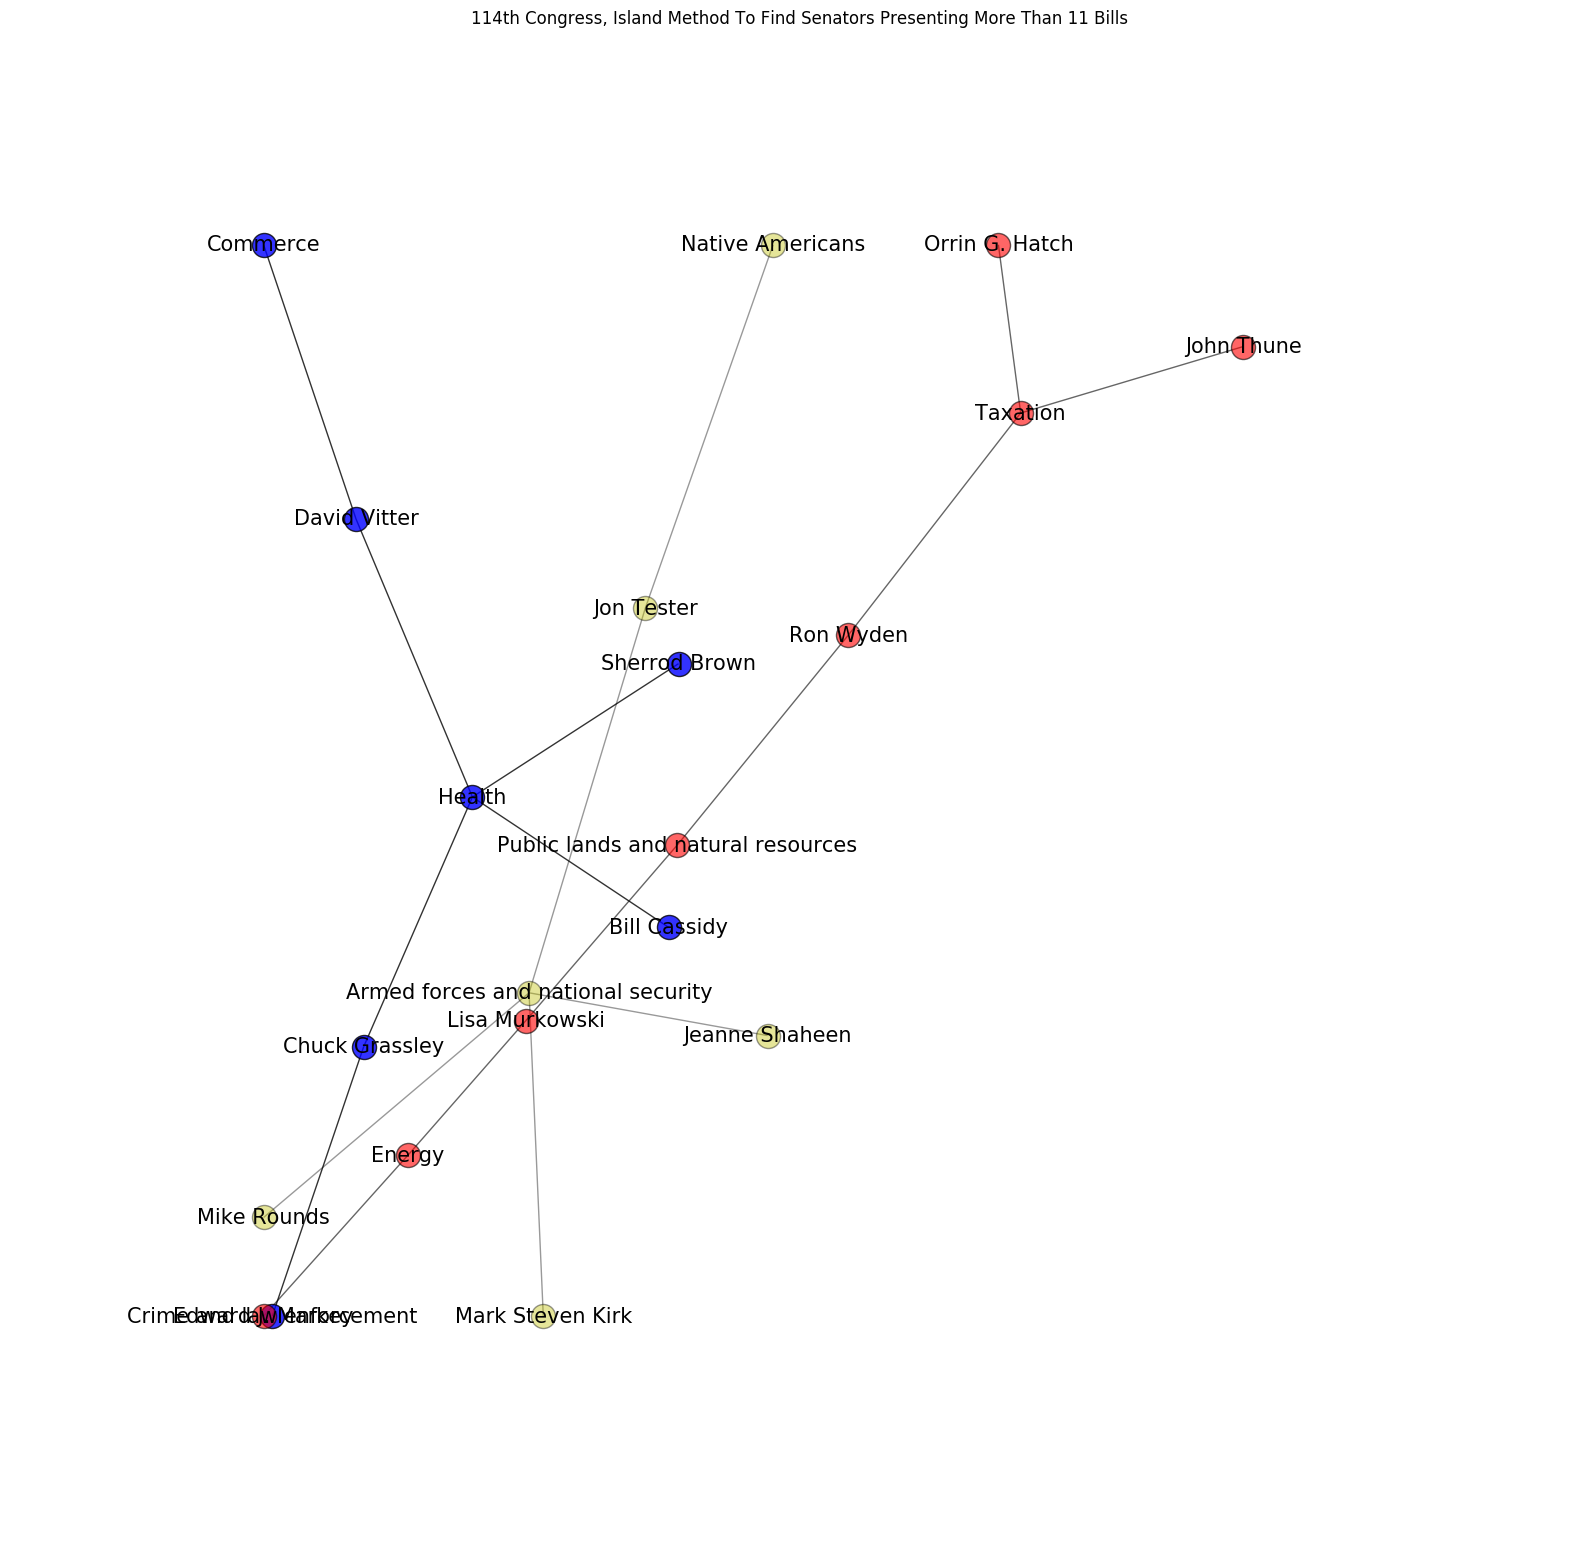

In [25]:
#Colors represent 3 different islands
%matplotlib inline
#pos = nx.erdos_renyi_graph(B)
fig = plt.figure(figsize=(15, 15))

for i in islands:
    if i[0] == 11:
        j = 0
        for c in nx.connected_component_subgraphs(i[1]):
            if j == 0:
                nx.draw(c, with_labels=True, font_size=15, alpha=.8, node_color = 'b')
            if j == 1:
                nx.draw(c, with_labels=True, font_size=15, alpha=.6, node_color = 'r')
            if j == 2:
                nx.draw(c, with_labels=True, font_size=15, alpha=.4, node_color = 'y')
            j = j + 1
            
plt.title('114th Congress, Island Method To Find Senators Presenting More Than 11 Bills')
plt.show()


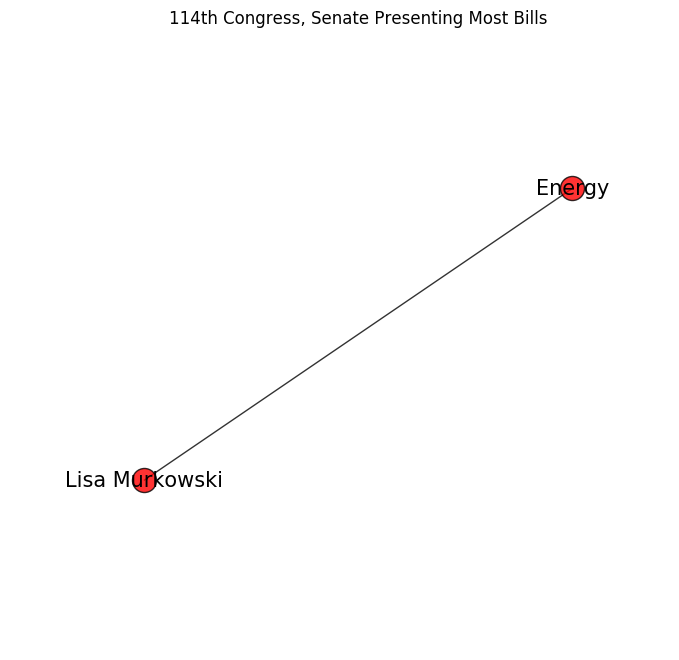

In [26]:
#Senetor presenting most bills on popular subject
%matplotlib inline
#pos = nx.erdos_renyi_graph(B)
fig = plt.figure(figsize=(6, 6))

for i in islands:
    if i[0] == 26:
        for c in nx.connected_component_subgraphs(i[1]):
            nx.draw(c, with_labels=True, font_size=15, alpha=.8, node_color = 'r')
            
plt.title('114th Congress, Senate Presenting Most Bills')
plt.show()